In [686]:
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt

In [135]:
dt = 1/(250) # number of steps per month (r is monthly yield)
num_steps = 100000
w = np.random.normal(0, np.sqrt(dt), size = num_steps)
rates = np.empty_like(w)

In [136]:
# parameters are assumed to be annual

kappa = 0.234
theta = 0.081
sig2 = 0.0073

In [137]:
rates[0] = 0.081

for step in range(1, num_steps):
    r_t = rates[step-1]
    d_r_t = kappa*(theta-r_t)*dt + np.sqrt(sig2*r_t)*w[step]
    rates[step] = abs(r_t + d_r_t)




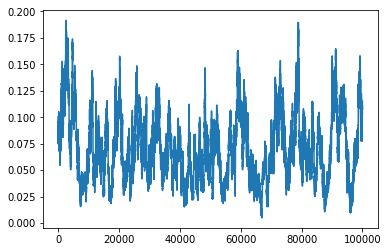

In [138]:
plt.plot(rates)

In [139]:
monthly_rates = rates[[250 * i for i in range(400)]]

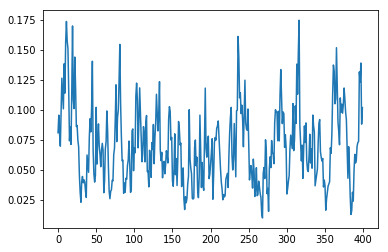

In [140]:
plt.plot(monthly_rates)

In [214]:
# define moment functions

def g1(theta, kappa, rates, t, dt):
    return (rates[t + 1] - rates[t] - kappa*(theta - rates[t])*dt)

def g2(theta, kappa, rates, t, dt):
    return rates[t]*g1(theta, kappa, rates, t, dt)

def g3(theta, kappa, sig2, rates, t, dt):
    return ((g1(theta, kappa, rates, t, dt))**2 - sig2*rates[t]*dt)

def g4(theta, kappa, sig2, rates, t, dt):
    return (rates[t] * g3(theta, kappa, sig2, rates, t, dt) - sig2*(rates[t]**2)*dt)

In [539]:
dt_input = 1
t_input = np.arange(0, 399)

W = np.identity(4)

def g(theta, kappa, sig2, monthly_rates, t_input, dt_input):

    return np.array([np.mean(g1(theta, kappa, monthly_rates, t_input, dt_input)),
                     np.mean(g2(theta, kappa, monthly_rates, t_input, dt_input)),
                     np.mean(g3(theta, kappa, sig2, monthly_rates, t_input, dt_input)),
                     np.mean(g4(theta, kappa, sig2, monthly_rates, t_input, dt_input))])

def G(pv):
    return g(pv[0], pv[1], pv[2], monthly_rates, t_input, dt_input)@W@g(pv[0], pv[1], pv[2], monthly_rates, t_input, dt_input)


In [540]:
theta_init = 0.1 #np.mean(monthly_rates)
kappa_init = 0.1 #0.234
sig2_init = 0.1 #0.0073
opt_input = [theta_init, kappa_init, sig2_init]

In [541]:
#for i in range(10):
    

res = optimize.minimize(G, x0 = opt_input, method = 'BFGS', tol = 1.e-9)
print(res.x)

[0.0704673  0.25751017 0.00636308]


In [542]:
# now we update W
def g_2(theta, kappa, sig2, monthly_rates, t_input, dt_input):

    return np.array([g1(theta, kappa, monthly_rates, t_input, dt_input),
                     g2(theta, kappa, monthly_rates, t_input, dt_input),
                     g3(theta, kappa, sig2, monthly_rates, t_input, dt_input),
                     g4(theta, kappa, sig2, monthly_rates, t_input, dt_input)])
S = np.zeros((4, 4))
for i in t_input:
    S += np.outer(g_2(opt_input[0], opt_input[1], opt_input[2], monthly_rates, i, 1), 
                  g_2(opt_input[0], opt_input[1], opt_input[2], monthly_rates, i, 1))

S/=len(t_input)
#center the matrix
S -= np.outer(g(opt_input[0], opt_input[1], opt_input[2], monthly_rates, t_input, 1), 
              g(opt_input[0], opt_input[1], opt_input[2], monthly_rates, t_input, 1))
S

array([[4.78517410e-04, 4.11374419e-05, 1.42729300e-05, 5.18332888e-06],
       [4.11374419e-05, 4.18227161e-06, 1.59511046e-06, 6.96504968e-07],
       [1.42729300e-05, 1.59511046e-06, 8.99374858e-06, 2.90110019e-06],
       [5.18332888e-06, 6.96504968e-07, 2.90110019e-06, 1.03859059e-06]])

In [543]:
W = np.linalg.inv(S)
W

array([[   17301.08640284,  -181756.86140284,   -67561.95630407,
          224266.75384209],
       [ -181756.86140284,  2188997.69607775,   819834.8642363 ,
        -2850945.58687722],
       [  -67561.95630407,   819834.8642363 ,  1430647.24090005,
        -4208852.11047402],
       [  224266.75384209, -2850945.58687722, -4208852.11047402,
        13512110.74492862]])

In [544]:
res = optimize.minimize(G, x0 = res.x, method = 'Nelder-Mead', tol = 1.e-8)
print(res.x)
opt_input = res.x  # looks okay, but why does the Covariance matrix explode if we attempt to iterate GMM?

[0.07199517 0.228951   0.00890458]


In [589]:
## QML

#for i in t_input:
i = 0

def lik(pv):
    theta = pv[0]
    kappa = pv[1]
    sig2 = pv[2]
    lik = 0
    for i in t_input:
        lik += norm.logpdf(monthly_rates[i + 1], monthly_rates[i] + kappa*(theta - monthly_rates[i]), 
                    np.sqrt(abs(sig2) * monthly_rates[i]))
    return -lik

In [593]:
optimize.minimize(lik, x0 = [0.1, 0.1, 0.1])  # looks good: hess_inv is our covariance matrix

      fun: -982.7846864711435
 hess_inv: array([[ 2.59552350e-04, -1.28862969e-03, -2.36561923e-06],
       [-1.28862969e-03,  6.50165632e-03,  1.44166364e-05],
       [-2.36561923e-06,  1.44166364e-05,  2.45361867e-07]])
      jac: array([-1.52587891e-05, -7.62939453e-06,  6.86645508e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 306
      nit: 13
     njev: 59
   status: 2
  success: False
        x: array([0.07048045, 0.24196066, 0.00674548])

In [712]:
##3. Shoji/Ozaki Approach
def SO_lik(pv):
    theta = pv[0]
    kappa = pv[1]
    sig = pv[2]
    lik = 0
    #A[i] uses r_i, and so with the others:
    A = (2/monthly_rates[t_input])*(kappa*theta - (sig**2)/4) - kappa*(monthly_rates[t_input])/2 
    B = (-2/(monthly_rates[t_input]**2)) * (kappa*theta - (sig**2)/4) - kappa/2
    C = (4/(monthly_rates[t_input]**3)) * (kappa*theta - (sig**2)/4)
    
    K = np.exp(B) - 1
    
    M = monthly_rates[t_input] + (A/B)*K + ((sig**2) * C)/(2 * (B**2))*(K - B)
    V = (sig**2)/(2*B) * (np.exp(2*B) - 1)
    

    for i in t_input:
        lik += -((monthly_rates[i + 1] - M[i])**2) / (2*V[i]) - (1/2)*np.log(2*np.pi*V[i])
    return -lik
    

In [713]:
SO_lik([0.08, 0.234, np.sqrt(0.0073)])

82960.9085571484

In [714]:
SO_lik([0.05, 0.1, 0.05])  # this number should be larger!  Something isn't right

7191.294170977457

In [669]:
#optimize.minimize(SO_lik, x0 = [0.08, 0.234, 0.081], bounds = [(0.05, 0.1), (0.1, 0.3), (0.05, 0.1)])

In [694]:
#4. Exact Likelihood
def exact_lik(pv):
    theta = pv[0]
    kappa = pv[1]
    sig = pv[2]
    lik = 0
    
    c = (2 * kappa) / ((sig**2) * (1 - np.exp(-kappa)) )
    u = c * monthly_rates * np.exp(-kappa)
    v = c * monthly_rates
    q = (2 * kappa * theta) / (sig**2) - 1
     
    for i in t_input:
        lik += np.log(c * np.exp(-(u[i] + v[i + 1])) * (v[i + 1] / u[i])**(q / 2) 
                      * special.iv(q, 2*np.sqrt(u[i] * v[i + 1])))
    return -lik


In [698]:
exact_lik([0.08, 0.234, np.sqrt(0.0073)])

-992.36196621953

In [700]:
optimize.minimize(exact_lik, x0 = [0.1, 0.1, 0.1], tol = 1.e-4)  # seems reasonable

      fun: -995.9398732374044
 hess_inv: array([[ 1.94091602e-05, -7.82888886e-05,  1.92297740e-09],
       [-7.82888886e-05,  1.88365021e-03,  7.87263845e-05],
       [ 1.92297740e-09,  7.87263845e-05,  1.39435713e-05]])
      jac: array([1.52587891e-05, 7.62939453e-05, 4.57763672e-05])
  message: 'Optimization terminated successfully.'
     nfev: 85
      nit: 11
     njev: 17
   status: 0
  success: True
        x: array([0.07048204, 0.27469511, 0.09129304])